## Data Analysis

### Data We Have

We have the following data:

 * `data/statements/contest_[en/ro].json` - the statements of the problems in the contest.
 * `data/solutions/solutions_[en/ro]_round_[1/2/3].json` - the solutions of the problems in the contest. We have 3 rounds for accounting for variations in the LLMs' answers.

TODO:
 * Take care of precision issues (maybe?).
 * Ro vs en statistics.

### Loading the Data

In [35]:
import matplotlib.pyplot as plt
import duckdb
import pandas as pd
import numpy as np
from collections import defaultdict

import internal_types

In [36]:
# For simplicity, only look at a single langauge for now.
LANG = "en"

# Load the data
statements_nested = duckdb.read_json(internal_types.get_statement_files()[LANG])
statements = duckdb.sql(
    "SELECT name as edition, generate_subscripts(problems, 1) - 1 AS problem_index, unnest(problems, recursive := true) FROM statements_nested"
)
solutions = duckdb.read_json(internal_types.get_solutions_files_glob()[LANG])
data_raw = duckdb.sql(
    "SELECT * FROM statements NATURAL JOIN solutions"
)
data = duckdb.sql(
    "SELECT *, answer = correct_answer AS correct FROM data_raw"
)

# Number of problems per contest.
NR_PROBLEMS = 20

# Number of contests.
NR_CONTESTS = 4

# The list with LLM models.
MODELS = [i[0] for i in duckdb.sql("SELECT DISTINCT llm FROM data").fetchall()]

# Number of times each model was run on each task.
RERUNS = len(data) // NR_CONTESTS // NR_PROBLEMS // len(MODELS)

def problem_index_to_difficulty(idx: int) -> str:
    """0-indexed idx to "easy", "medium" or "hard"."""
    assert 0 <= idx < NR_PROBLEMS
    if idx < 10:
        return "easy"
    elif idx < 16:
        return "medium"
    else:
        return "hard"

### Computing the average accuracy by LLM

We are computing the average accuracy by LLM for each problem category (easy / medium / hard).

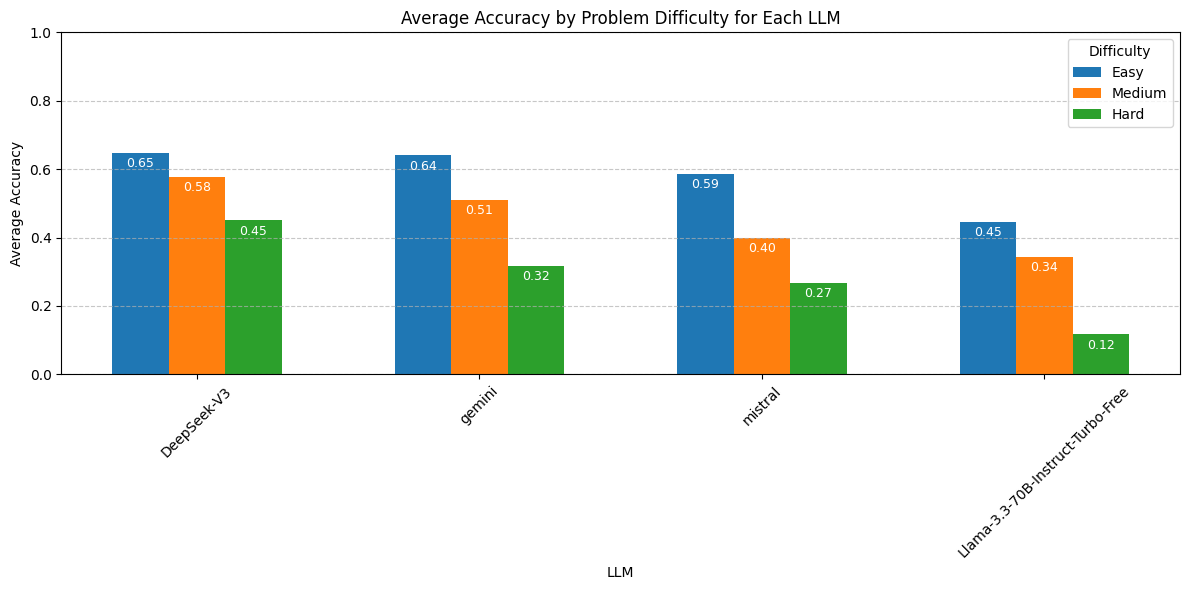

In [46]:
# Extract data from DuckDB
df = duckdb.sql(
"""
    SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
    FROM data
    GROUP BY edition, problem_index, llm
""").df()

plot_data = { model: { "easy": [], "medium": [], "hard": [] } for model in MODELS }
for _, row in df.iterrows():
    plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(row["accuracy"])

# Plot the data


# Calculate average accuracy for each difficulty level
average_plot_data = {
    model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
    for model, data in plot_data.items()
}

# Plot the data
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(MODELS))

for i, difficulty in enumerate(["easy", "medium", "hard"]):
    accuracies = [average_plot_data[model][difficulty] for model in MODELS]
    bars = plt.bar(
        index + i * bar_width, accuracies, bar_width, label=f"{difficulty.capitalize()}"
    )

    # Add values on top of the bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.05,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM")
plt.xticks(index + bar_width, MODELS, rotation=45)
plt.ylim(0, 1)
plt.legend(title="Difficulty")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Computing Success rate when using Python

Writing python code is challenging, so seeing the success rate of the LLMs when using Python is interesting.

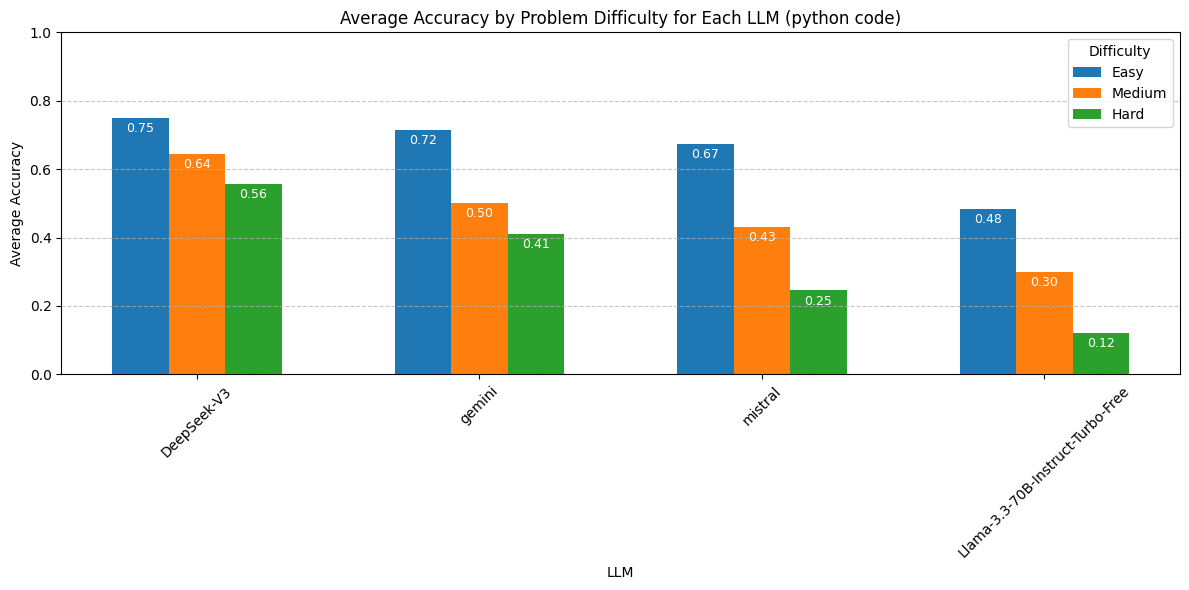

In [47]:
# Extract data from DuckDB
df = duckdb.sql(
    """
    SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy, COUNT(*) as total
    FROM data
    WHERE python_code IS NOT NULL
    GROUP BY edition, problem_index, llm
"""
).df()


plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
for _, row in df.iterrows():
    plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
        row["accuracy"]
    )

# Plot the data

# Calculate average accuracy for each difficulty level
average_plot_data = {
    model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
    for model, data in plot_data.items()
}

# Plot the data
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(MODELS))

for i, difficulty in enumerate(["easy", "medium", "hard"]):
    accuracies = [average_plot_data[model][difficulty] for model in MODELS]
    bars = plt.bar(
        index + i * bar_width, accuracies, bar_width, label=f"{difficulty.capitalize()}"
    )

    # Add values on top of the bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.05,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM (python code)")
plt.xticks(index + bar_width, MODELS, rotation=45)
plt.ylim(0, 1)
plt.legend(title="Difficulty")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [44]:
duckdb.sql("select * from data where python_code IS NOT NULL")

┌─────────────┬───────────────┬──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:

plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
for _, row in df.iterrows():
    plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
        row["accuracy"]
    )

# Plot the data

# Calculate average accuracy for each difficulty level
average_plot_data = {
    model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
    for model, data in plot_data.items()
}


# Calculate average accuracy for each difficulty level
average_plot_data = {
    model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
    for model, data in plot_data.items()
}

# Plot the data
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(MODELS))

for i, difficulty in enumerate(["easy", "medium", "hard"]):
    accuracies = [average_plot_data[model][difficulty] for model in MODELS]
    bars = plt.bar(
        index + i * bar_width, accuracies, bar_width, label=f"{difficulty.capitalize()}"
    )

    # Add values on top of the bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.05,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM")
plt.xticks(index + bar_width, MODELS, rotation=45)
plt.ylim(0, 1)
plt.legend(title="Difficulty")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
for row in df.iterrows():
    print(row)

(0, edition          Ediția 2024
problem_index              0
llm                  mistral
correct                  0.0
accuracy                 0.0
Name: 0, dtype: object)
(1, edition                                Ediția 2024
problem_index                                    0
llm              Llama-3.3-70B-Instruct-Turbo-Free
correct                                        0.0
accuracy                                       0.0
Name: 1, dtype: object)
(2, edition          Ediția 2024
problem_index              5
llm                   gemini
correct                  3.0
accuracy                 1.0
Name: 2, dtype: object)
(3, edition          Ediția 2024
problem_index             12
llm              DeepSeek-V3
correct                  3.0
accuracy                 1.0
Name: 3, dtype: object)
(4, edition          Ediția 2024
problem_index             16
llm                  mistral
correct                  2.0
accuracy            0.666667
Name: 4, dtype: object)
(5, edition              

In [30]:
df

,edition,problem_index,llm,correct,accuracy
0,Ediția 2024,0,mistral,0.0,0.000000
1,Ediția 2024,0,Llama-3.3-70B-Instruct-Turbo-Free,0.0,0.000000
2,Ediția 2024,5,gemini,3.0,1.000000
3,Ediția 2024,12,DeepSeek-V3,3.0,1.000000
4,Ediția 2024,16,mistral,2.0,0.666667
...,...,...,...,...,...
395,Ediția 2021,18,Llama-3.3-70B-Instruct-Turbo-Free,0.0,0.000000
396,Ediția 2024,19,mistral,3.0,1.000000
397,Ediția 2024,19,Llama-3.3-70B-Instruct-Turbo-Free,2.0,0.666667
398,Ediția 2021,0,gemini,2.0,0.666667


In [ ]:

# Convert to DataFrame
df = pd.DataFrame(
    data, columns=["edition", "llm", "problem_index", "answer", "correct_answer"]
)

# Calculate correctness
df["is_correct"] = df.apply(lambda row: row["answer"] == row["correct_answer"], axis=1)

# Group by LLM and calculate average, best, and worst accuracy
accuracy_by_llm = (
    df.groupby("llm")["is_correct"].agg(["mean", "max", "min"]).reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    accuracy_by_llm["llm"],
    accuracy_by_llm["mean"],
    color="skyblue",
    label="Average Accuracy",
)
plt.errorbar(
    accuracy_by_llm["llm"],
    accuracy_by_llm["mean"],
    yerr=[
        accuracy_by_llm["mean"] - accuracy_by_llm["min"],
        accuracy_by_llm["max"] - accuracy_by_llm["mean"],
    ],
    fmt="o",
    color="red",
    capsize=5,
    label="Best/Worst Performance",
)

plt.title("Average Accuracy by Model with Best and Worst Performances")
plt.xlabel("LLM")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()